In [4]:
import cv2
import torch
import os
from typing import Any
import torch
from torch import Tensor
from torch import nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import time
import copy
import tqdm
import torchvision.transforms as transforms
from torchmetrics.classification import MultilabelAccuracy, Accuracy
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath('../'))

In [20]:
from dataset import *


TRAIN_RATIO  = 0.2
IMG_DIR = '../data/images_for_TH'
CSV_PATH = '../csvs/TH_dataset.csv'
IMG_SIZE = 640
# epoch>>200
BATCH_SIZE = 32
# loss>>multi
# rearning_rate>>0.0005
# rl_patience>>10
# dropout_rate>>0.0

In [14]:
def get_transforms(use_horizontal_flip=False,
                   use_vertical_flip=False,
                   use_rotation=False,
                   use_color_jitter=False,
                   img_size=640,
                   brightness=0.3,
                   contrast=0.3,
                   saturation=0.3,
                   rotation_degrees=359):
    """
    데이터 증강을 위한 변환(transform) 목록을 생성하는 함수.

    Args:
        use_horizontal_flip (bool): 좌우 반전을 사용할지 여부.
        use_vertical_flip (bool): 상하 반전을 사용할지 여부.
        use_rotation (bool): 회전을 사용할지 여부.
        use_color_jitter (bool): 밝기, 대비, 채도 변화를 사용할지 여부.

        brightness (float): 밝기 조절의 범위.
        contrast (float): 대비 조절의 범위.
        saturation (float): 채도 조절의 범위.

        rotation_degrees (int): 랜덤 회전의 최대 각도.

    Returns:
        transforms.Compose: 변환이 적용된 Compose 객체.
    """
    transform_list = []

    # 좌우 반전 추가
    if use_horizontal_flip:
        transform_list.append(transforms.RandomHorizontalFlip(p=0.5))

    if use_vertical_flip:
        transform_list.append(transforms.RandomVerticalFlip(p=0.5))

    # 랜덤 회전 추가
    if use_rotation:
        transform_list.append(transforms.RandomRotation(degrees=rotation_degrees))

    # Color Jitter 추가
    if use_color_jitter:
        transform_list.append(transforms.ColorJitter(
            brightness=brightness,
            contrast=contrast,
            saturation=saturation
        ))

    # 텐서 변환 및 정규화 추가
    transform_list.append(transforms.Resize(img_size))
    transform_list.append(transforms.ToTensor())

    # 변환 목록을 Compose로 반환
    return transforms.Compose(transform_list)

train_df, val_df,test_df, NUM_CLS, cls_list = get_data_from_csv_TH(csv_path=CSV_PATH,img_dir=IMG_DIR, train_ratio=TRAIN_RATIO, randoms_state=42)

transformation = get_transforms(img_size=IMG_SIZE,
                                brightness=0.3,
                                contrast=0.3,
                                saturation=0.3,
                                rotation_degrees=359)

train_set = CustomDataset(train_df,num_classes=NUM_CLS, image_dir=IMG_DIR, class_list= cls_list ,img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
train_set.transforms = transformation

val_set = CustomDataset(val_df,num_classes=NUM_CLS, image_dir=IMG_DIR, class_list= cls_list, img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
val_set.transforms = transformation

test_set = CustomDataset(test_df,num_classes=NUM_CLS, image_dir=IMG_DIR, class_list= cls_list, img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
test_set.transforms = transformation

####################################################################################
############################# 과제용임!!!!!!!! ######################################
####################################################################################


validating all images: 100%|██████████| 2800/2800 [00:00<00:00, 7865.20it/s]

num of train_df 560
num of val_df 1120
num of test_df 1120
number of class:  6
['no_lens', 'etc', 'burr', 'borken', 'b_edge', 'b_bubble']


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_max_memory_allocated(device=None)
torch.cuda.empty_cache()
print(device)

cuda


In [18]:
from ViT import ViT

model_ViT = ViT(num_classes=NUM_CLS)
model_ViT.load_state_dict(torch.load('../models/vit/37_weight.pt'))

model_ViT = model_ViT.to(device=device)


In [ ]:
csv_path = 'TH_dataset.csv'
img_dir = './data/images2/'

IMG_SIZE = 640
BATCH_SIZE = 96
EPOCH = 200

In [21]:
Vit_result = []
actual = []
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

for xb, yb in test_loader:
    xb = xb.to(device)
    with torch.no_grad():
        output = model_ViT(xb)

    pred = output.sigmoid() >= 0.5

    Vit_result.extend(pred.detach().cpu().numpy())  # tensor를 numpy 배열로 변환
    actual.extend(yb.detach().cpu().numpy())
    # 메모리 해제
    del xb, yb, output,pred
    torch.cuda.empty_cache()  # 캐시된 메모리 해제


Precision: 0.80702
Recall: 0.48421
F1 Score: 0.60526
Accuracy: 0.53929


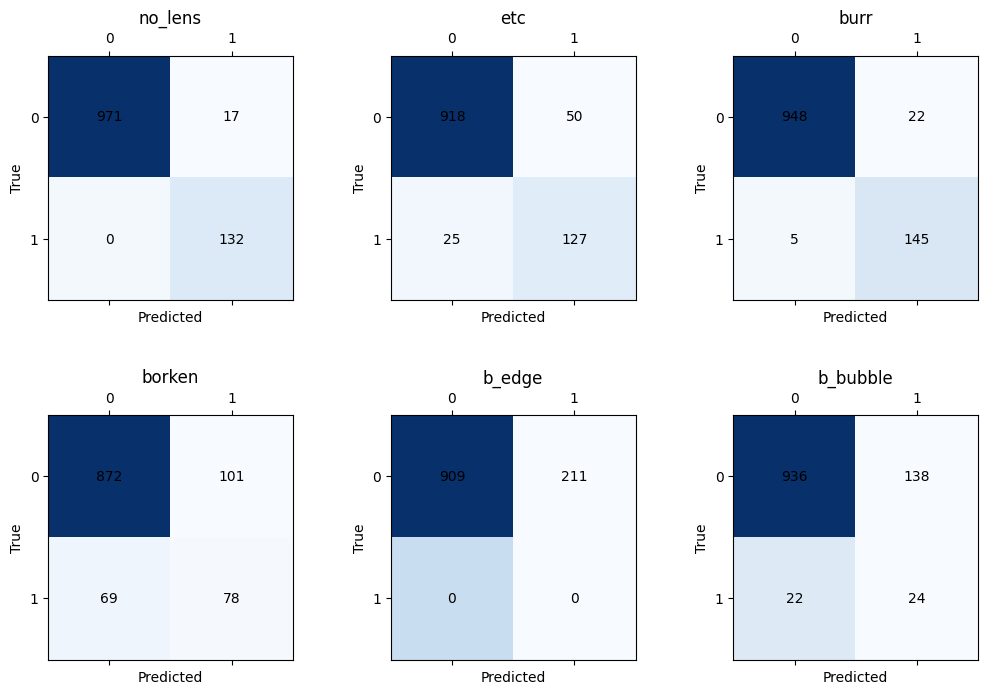

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
labels = ['no_lens', 'etc', 'burr', 'borken', 'b_edge', 'b_bubble']

# 멀티레이블 분류의 정밀도, 재현율, F1 점수 계산
precision = precision_score(actual, Vit_result, average='micro')
recall = recall_score(actual, Vit_result, average='micro')
f1 = f1_score(actual, Vit_result, average='micro')
accuracy = accuracy_score(actual, Vit_result)

print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1))
print('Accuracy: {:.5f}'.format(accuracy))

mcm = multilabel_confusion_matrix(actual, Vit_result)
fig, ax = plt.subplots(2, 3, figsize=(12, 8))  # 2x3 그리드 생성
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # 서브플롯 간 간격 조정

# 각 레이블에 대한 confusion matrix 시각화
for i, (label_mcm) in enumerate(mcm):
    # 현재 서브플롯 선택
    row = i // 3
    col = i % 3
    cax = ax[row, col]

    # confusion matrix 표시
    cax.matshow(label_mcm, cmap='Blues')  # 색상 테마 선택

    # 축 레이블 설정
    cax.set_xlabel('Predicted')
    cax.set_ylabel('True')
    cax.set_title(labels[i])

    # 각 셀에 대한 값 표시
    for (x, y), value in np.ndenumerate(label_mcm):
        cax.text(x, y, f'{value}', va='center', ha='center')

# 그래프 표시
plt.show()

Precision: 0.83375
Recall: 0.64522
F1 Score: 0.72747
Accuracy: 0.61964


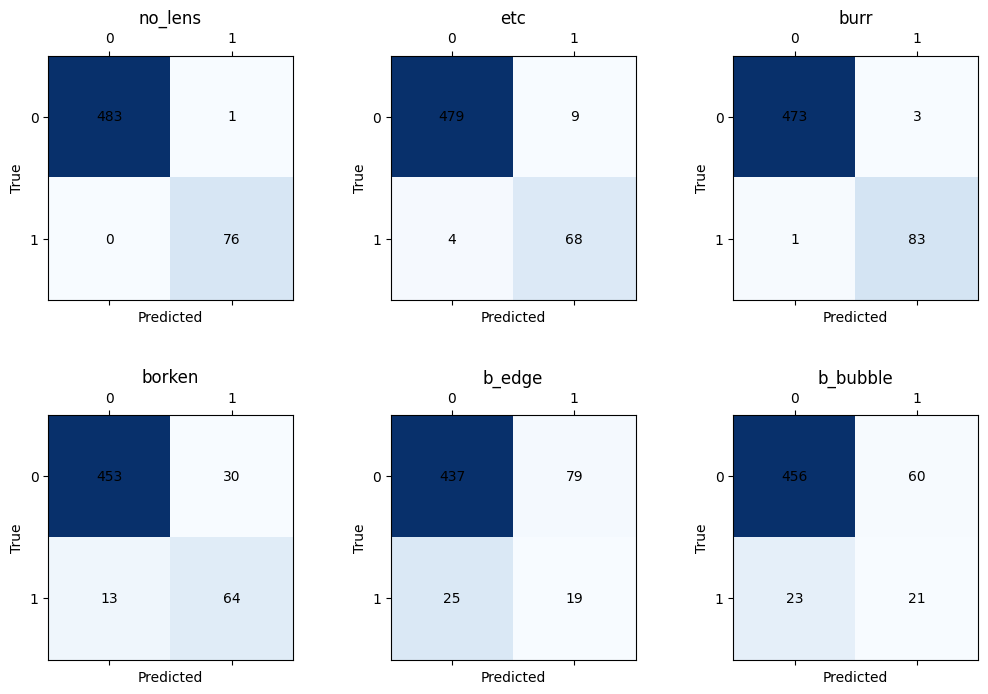

In [ ]:
# 멀티레이블 분류의 정밀도, 재현율, F1 점수 계산
precision = precision_score(actual, TH_result, average='micro')
recall = recall_score(actual, TH_result, average='micro')
f1 = f1_score(actual, TH_result, average='micro')
accuracy = accuracy_score(actual, TH_result)

print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1))
print('Accuracy: {:.5f}'.format(accuracy))

mcm = multilabel_confusion_matrix(actual, TH_result)
fig, ax = plt.subplots(2, 3, figsize=(12, 8))  # 2x3 그리드 생성
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # 서브플롯 간 간격 조정

# 각 레이블에 대한 confusion matrix 시각화
for i, (label_mcm) in enumerate(mcm):
    # 현재 서브플롯 선택
    row = i // 3
    col = i % 3
    cax = ax[row, col]

    # confusion matrix 표시
    cax.matshow(label_mcm, cmap='Blues')  # 색상 테마 선택

    # 축 레이블 설정
    cax.set_xlabel('Predicted')
    cax.set_ylabel('True')
    cax.set_title(labels[i])

    # 각 셀에 대한 값 표시
    for (x, y), value in np.ndenumerate(label_mcm):
        cax.text(x, y, f'{value}', va='center', ha='center')

# 그래프 표시
plt.show()